# 기온 예측 문제

In [1]:
import os

data_dir = "datasets/jena_climate/"
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

In [2]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

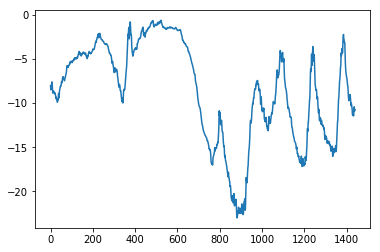

In [5]:
plt.plot(range(1440), temp[:1440])

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size =batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle = True,
                      step = step,
                      batch_size =batch_size)
val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      step = step,
                      batch_size =batch_size)
test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      step = step,
                      batch_size =batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [9]:
def evaluate_native_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_native_method()

0.2897359729905486


In [10]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

## 기본적인 머신 러닝

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [12]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 14s 29ms/step - loss: 1.4326 - val_loss: 0.6737
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.4680 - val_loss: 0.4874
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2993 - val_loss: 0.3444
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2668 - val_loss: 0.3194
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2520 - val_loss: 0.3059
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2434 - val_loss: 0.3213
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2359 - val_loss: 0.3233
Epoch 8/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2293 - val_loss: 0.3337
Epoch 9/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2258 - val_loss: 0.3277
Epoch 10/20
500/500 [==============================] - 11s 22ms/step - loss: 0.219

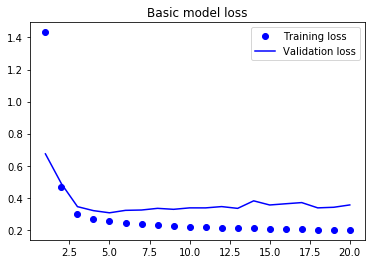

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Basic model loss')
plt.legend()

plt.show()

## 1  GRU

In [16]:
model = Sequential()
model.add(layers.GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 164s 328ms/step - loss: 0.3020 - val_loss: 0.2684
Epoch 2/20
500/500 [==============================] - 175s 351ms/step - loss: 0.2862 - val_loss: 0.2672
Epoch 3/20
500/500 [==============================] - 166s 333ms/step - loss: 0.2812 - val_loss: 0.2653
Epoch 4/20
500/500 [==============================] - 165s 330ms/step - loss: 0.2752 - val_loss: 0.2643
Epoch 5/20
500/500 [==============================] - 161s 322ms/step - loss: 0.2706 - val_loss: 0.2700
Epoch 6/20
500/500 [==============================] - 174s 347ms/step - loss: 0.2661 - val_loss: 0.2693
Epoch 7/20
500/500 [==============================] - 167s 333ms/step - loss: 0.2619 - val_loss: 0.2708
Epoch 8/20
500/500 [==============================] - 160s 320ms/step - loss: 0.2556 - val_loss: 0.2732
Epoch 9/20
500/500 [==============================] - 162s 323ms/step - loss: 0.2503 - val_loss: 0.2745
Epoch 10/20
500/500 [==============================] - 159s 319m

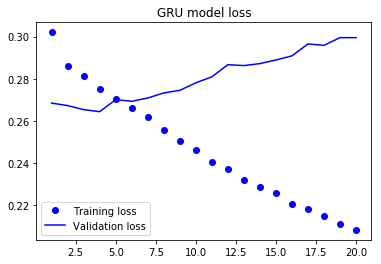

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GRU model loss')
plt.legend()

plt.show()

## Use Dropout

In [22]:
model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 204s 408ms/step - loss: 0.3455 - val_loss: 0.2750
Epoch 2/40
500/500 [==============================] - 191s 383ms/step - loss: 0.3143 - val_loss: 0.2726
Epoch 3/40
500/500 [==============================] - 194s 388ms/step - loss: 0.3077 - val_loss: 0.2698
Epoch 4/40
500/500 [==============================] - 190s 380ms/step - loss: 0.3051 - val_loss: 0.2701
Epoch 5/40
500/500 [==============================] - 193s 385ms/step - loss: 0.3007 - val_loss: 0.2703
Epoch 6/40
500/500 [==============================] - 193s 386ms/step - loss: 0.2970 - val_loss: 0.2681
Epoch 7/40
500/500 [==============================] - 192s 384ms/step - loss: 0.2947 - val_loss: 0.2704
Epoch 8/40
500/500 [==============================] - 202s 404ms/step - loss: 0.2936 - val_loss: 0.2662
Epoch 9/40
500/500 [==============================] - 177s 354ms/step - loss: 0.2931 - val_loss: 0.2675
Epoch 10/40
500/500 [==============================] - 182s 364m

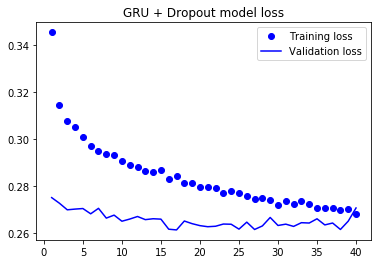

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GRU + Dropout model loss')
plt.legend()

plt.show()

## GRU + Dropout + Add layer model

In [28]:
model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 432s 864ms/step - loss: 0.3369 - val_loss: 0.2785
Epoch 2/40
500/500 [==============================] - 393s 785ms/step - loss: 0.3135 - val_loss: 0.2749
Epoch 3/40
500/500 [==============================] - 396s 792ms/step - loss: 0.3059 - val_loss: 0.2710
Epoch 4/40
500/500 [==============================] - 397s 795ms/step - loss: 0.3023 - val_loss: 0.2712
Epoch 5/40
500/500 [==============================] - 397s 793ms/step - loss: 0.2984 - val_loss: 0.2667
Epoch 6/40
500/500 [==============================] - 399s 797ms/step - loss: 0.2960 - val_loss: 0.2698
Epoch 7/40
500/500 [==============================] - 1059s 2s/step - loss: 0.2913 - val_loss: 0.2663
Epoch 8/40
500/500 [==============================] - 315s 630ms/step - loss: 0.2891 - val_loss: 0.2653
Epoch 9/40
500/500 [==============================] - 310s 620ms/step - loss: 0.2898 - val_loss: 0.2666
Epoch 10/40
500/500 [==============================] - 308s 616ms/

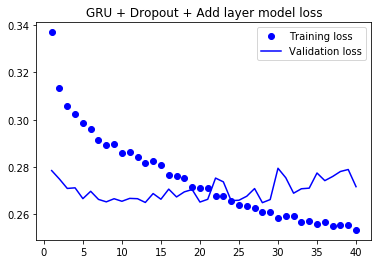

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GRU + Dropout + Add layer model loss')
plt.legend()

plt.show()

## bidirectional GRU

In [30]:
model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='RMSprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 268s 536ms/step - loss: 0.2962 - val_loss: 0.2985
Epoch 2/40
500/500 [==============================] - 267s 534ms/step - loss: 0.2747 - val_loss: 0.2701
Epoch 3/40
500/500 [==============================] - 267s 534ms/step - loss: 0.2661 - val_loss: 0.2661
Epoch 4/40
500/500 [==============================] - 266s 531ms/step - loss: 0.2603 - val_loss: 0.2688
Epoch 5/40
500/500 [==============================] - 265s 531ms/step - loss: 0.2551 - val_loss: 0.2726
Epoch 6/40
500/500 [==============================] - 266s 531ms/step - loss: 0.2507 - val_loss: 0.2686
Epoch 7/40
500/500 [==============================] - 262s 524ms/step - loss: 0.2456 - val_loss: 0.2721
Epoch 8/40
500/500 [==============================] - 261s 521ms/step - loss: 0.2393 - val_loss: 0.2747
Epoch 9/40
500/500 [==============================] - 260s 521ms/step - loss: 0.2337 - val_loss: 0.2802
Epoch 10/40
500/500 [==============================] - 261s 521m

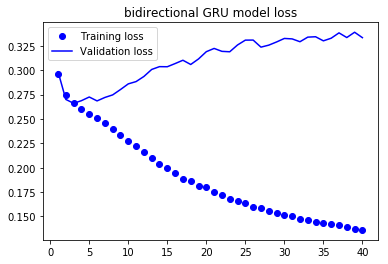

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('bidirectional GRU model loss')
plt.legend()

plt.show()

# --------------------------------------------------------
# 08_RNN_processing_with_convnets

In [32]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

max_features = 10000
max_len = 500

print("data load...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), "train sequence")
print(len(x_test), "test sequence")

print("sequence padding (samples x tiem)")
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print("size of x_train : ", x_train.shape)
print("size of x_test  : ", x_test.shape)

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1))

model.summary()

data load...
25000 train sequence
25000 test sequence
sequence padding (samples x tiem)
size of x_train :  (25000, 500)
size of x_test  :  (25000, 500)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 3

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 202us/step - loss: 0.8337 - acc: 0.5088 - val_loss: 0.6875 - val_acc: 0.5630
Epoch 2/10
20000/20000 [==============================] - 2s 111us/step - loss: 0.6700 - acc: 0.6400 - val_loss: 0.6642 - val_acc: 0.6582
Epoch 3/10
20000/20000 [==============================] - 2s 111us/step - loss: 0.6235 - acc: 0.7557 - val_loss: 0.6078 - val_acc: 0.7426
Epoch 4/10
20000/20000 [==============================] - 2s 124us/step - loss: 0.5257 - acc: 0.8089 - val_loss: 0.4852 - val_acc: 0.8064
Epoch 5/10
20000/20000 [==============================] - 2s 124us/step - loss: 0.4086 - acc: 0.8487 - val_loss: 0.4308 - val_acc: 0.8294
Epoch 6/10
20000/20000 [==============================] - 2s 124us/step - loss: 0.3463 - acc: 0.8670 - val_loss: 0.4139 - val_acc: 0.8402
Epoch 7/10
20000/20000 [==============================] - 2s 123us/step - loss: 0.3085 - acc: 0.8713 - val_loss: 0.4411 - v

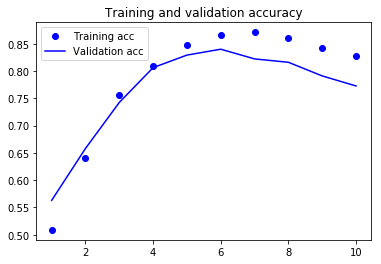

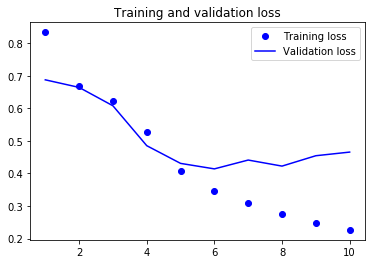

In [33]:
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
import os
import numpy as np

data_dir = './datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total para

Epoch 1/20
500/500 [==============================] - 12s 25ms/step - loss: 0.4184 - val_loss: 0.4470
Epoch 2/20
500/500 [==============================] - 11s 23ms/step - loss: 0.3626 - val_loss: 0.4549
Epoch 3/20
500/500 [==============================] - 10s 19ms/step - loss: 0.3382 - val_loss: 0.4653
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3223 - val_loss: 0.4568
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3086 - val_loss: 0.4444
Epoch 6/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3004 - val_loss: 0.4558
Epoch 7/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2921 - val_loss: 0.4530
Epoch 8/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2871 - val_loss: 0.5214
Epoch 9/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2801 - val_loss: 0.4808
Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2746 - va

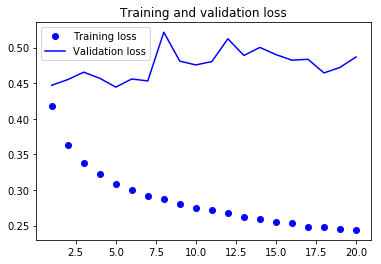

In [35]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [36]:
step = 3
lookback = 1440
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_14 (GRU)                 (None, 32)                6240      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
500/500 [==============================] - 109s 219ms/step - loss: 0.3403 - val_loss: 0.2933
Epoch 2/20
500/500 [==============================] - 109s 218ms/step - loss: 0.3069 - val_loss: 0.2792
Epoch 3/20
500/500 [==============================] - 108s 215ms/step - loss: 0.2940 - val_loss: 0.2755
Epoch 4/20
500/500 [==============================] - 108s 215ms/step - loss: 0.2855 - val_loss: 0.2790
Epoch 5/20
500/500 [==============================] - 109s 218ms/step - loss: 0.2778 - val_loss: 0.2769
Epoch 6/20
500/500 [==============================] - 108s 215ms/step - loss: 0.2734 - val_loss: 0.2912
Epoch 7/20
500/500 [==============================] - 108s 216ms/step - loss: 0.2672 - val_loss: 0.2804
Epoch 8/20
500/500 [==============================] - 109s 218ms/step - loss: 0.2609 - val_loss: 0.2801
Epoch 9/20
500/500 [==============================] - 108s 216ms/step - loss: 0.2567 - val_loss: 0.2747
Epoch 10/20
500/500 [==============================] - 108s 215m

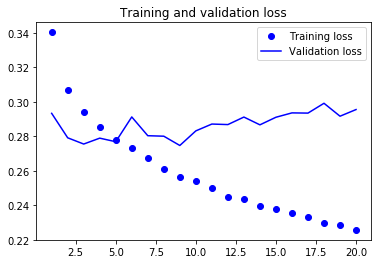

In [37]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()